In [1]:
import os
import onnx
import torch

model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cnn-dizeratie"
print("Model dir:", model_dir)
torch.set_num_threads(2)

Model dir: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie


In [2]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 808.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 8.5 MB/s eta 0:00:00


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir -p data_uta_rldd
!kaggle datasets download -d minhngt02/uta-rldd -p data_uta_rldd --force
!ls data_uta_rldd

Dataset URL: https://www.kaggle.com/datasets/minhngt02/uta-rldd
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 2.76G/2.77G [00:02<00:00, 1.26GB/s]
100%|██████████████████████████████████████| 2.77G/2.77G [00:02<00:00, 1.01GB/s]
UTA_RLDD_raw  uta-rldd.zip


In [5]:
!unzip -oq data_uta_rldd/uta-rldd.zip -d data_uta_rldd/UTA_RLDD_raw
print("Unzip completed.")

Unzip completed.


In [6]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder

# -------------------------------------------------------
# 1. Root folder where you unzipped the UTA-RLDD Kaggle dataset
#    Adjust this path to match your environment.
# -------------------------------------------------------
uta_root = "data_uta_rldd/UTA_RLDD_raw"   # <-- change if needed

train_root = os.path.join(uta_root, "train")
val_root   = os.path.join(uta_root, "val")
test_root  = os.path.join(uta_root, "test")

# -------------------------------------------------------
# 2. Transforms: resize to 128x128, tensor + normalization
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# 2) No augmentation, only resize + normalize: VAL/TEST
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5]),
# ])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

full_dataset = ImageFolder(root= os.path.join(uta_root, "train") , transform=transform)
# -------------------------------------------------------
# 3. Build train / val / test datasets from folders
# -------------------------------------------------------
train_quantized_dataset = ImageFolder(root=train_root, transform=transform)
val_quantized_dataset   = ImageFolder(root=val_root,   transform=eval_transform)
test_quantized_dataset  = ImageFolder(root=test_root,  transform=eval_transform)

print("Classes:", train_quantized_dataset.classes)
print("Train images:", len(train_quantized_dataset))
print("Val   images:", len(val_quantized_dataset))
print("Test  images:", len(test_quantized_dataset))

# Inspect one sample from train
x0, y0 = train_quantized_dataset[0]
print("Sample shape:", x0.shape)        # (3, 128, 128)
print("Sample label index:", y0)        # 0 or 1
print("Label name:", train_quantized_dataset.classes[y0])
print("Class names:", full_dataset.classes)

Classes: ['active', 'fatigue']
Train images: 9054
Val   images: 1824
Test  images: 909
Sample shape: torch.Size([3, 128, 128])
Sample label index: 0
Label name: active
Class names: ['active', 'fatigue']


Random TRAIN sample:


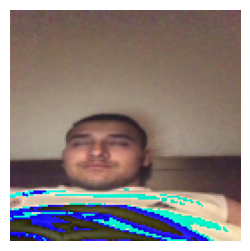

Title: Train sample
Label index: 1
--------------------------------------------------
Random TEST sample:


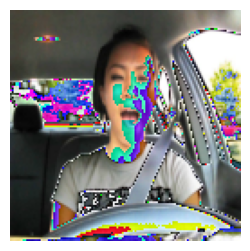

Title: Test sample
Label index: 1
--------------------------------------------------


In [7]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_random_sample_from_subset(subset, title):
    # subset is a torch.utils.data.Subset
    # subset.dataset is the underlying ImageFolder
    # subset.indices is the list of indices into the ImageFolder

    # pick a random index inside the subset
    subset_idx = random.randint(0, len(subset) - 1)
    # real_idx = subset.indices[subset_idx]   # index inside ImageFolder

    # get image + label
    img, label = subset[subset_idx]

    # get file path
    # filepath, _ = subset.dataset.samples[real_idx]

    # convert tensor to PIL for display
    img_pil = F.to_pil_image(img)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_pil)
    # plt.title(f"{title}\nLabel: {subset.dataset.classes[label]}")
    plt.axis("off")
    plt.show()

    # also print details in text
    print(f"Title: {title}")
    print(f"Label index: {label}")
    # print(f"Label name: {subset.dataset.classes[label]}")
    # print(f"File path: {filepath}")
    print("--------------------------------------------------")


print("Random TRAIN sample:")
show_random_sample_from_subset(train_quantized_dataset, "Train sample")

print("Random TEST sample:")
show_random_sample_from_subset(test_quantized_dataset, "Test sample")


In [8]:
from torch.utils.data import DataLoader

batch_size = 16   # safer for larger images; adjust later if needed

train_quantized_loader = DataLoader(
    train_quantized_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # try 4; reduce to 0 if errors
    pin_memory=False
)

test_quantized_loader = DataLoader(
    test_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

val_quantized_loader = DataLoader(
    val_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

In [9]:
count = 0
for x, y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

Input shape for 1 batch: torch.Size([16, 3, 128, 128])
Label shape for 1 batch: torch.Size([16])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


In [11]:
num_classes = len(full_dataset.classes) 
print("Number of classes:", num_classes, "->", full_dataset.classes)

Number of classes: 2 -> ['active', 'fatigue']


In [12]:
#### MODEL 6 #### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN(nn.Module):
    """
    Lighter version of the Keras-style model:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.5) -> Dense(32) -> Dense(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # --------- Block 1: 3 -> 16 ---------
        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # H,W: 128 -> 64

        # --------- Block 2: 16 -> 32 ---------
        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64 -> 32

        # --------- Block 3: 32 -> 32 ---------
        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32 -> 16

        # --------- Block 4: 32 -> 32 ---------
        self.conv4 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act4 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool4 = nn.MaxPool2d(2, 2)   # 16 -> 8

        # --------- Compute feature_dim automatically ---------
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]   # should be 32 * 8 * 8 = 2048 for 128x128

        # --------- Dropout + FC layers ---------
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=32,   # smaller hidden layer
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )

        self.fc2 = QuantLinear(
            in_features=32,
            out_features=num_classes,   # 2 for drowsy/active
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)   # flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.fc2(x)             # logits
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=input_h,
#     input_width=input_w,
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)

In [13]:
#############################
######## MODEL 6.1 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_1(nn.Module):
    """
    Model 6.1:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        # feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # for 128: 32*8*8 = 2048

        # Head
        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_1(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model.name)
# print("feature_dim:", model.feature_dim)


In [14]:
#############################
######## MODEL 6.2 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_2(nn.Module):
    """
    Model 6.2:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(48) + MaxPool
      Conv(64) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 48, 32 -> 16
        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 48 -> 64, 16 -> 8
        self.conv4 = QuantConv2d(48, 64, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 64*8*8 = 4096

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_2(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [15]:
#############################
######## MODEL 6.3 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_3(nn.Module):
    """
    Model 6.3:
      Same as Model 6 conv widths, but adds Dropout2d(p=0.1) in the conv trunk
      (training-only) + head like 6.1.
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Dropout2d in trunk (training-only)
        self.drop2 = nn.Dropout2d(p=0.1)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop3 = nn.Dropout2d(p=0.1)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.drop2(x)
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.drop3(x)
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_3(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [16]:
### Model 8 ### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class Model8_Bottleneck1x1(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16 -> (1x1) -> 8, pool
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv1b = QuantConv2d(16, 8, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128->64

        # Block 2: 8 -> 16 -> (1x1) -> 16, pool
        self.conv2 = QuantConv2d(8, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv2b = QuantConv2d(16, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64->32

        # Block 3: 16 -> 32, pool
        self.conv3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32->16

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(dummy)))))
            x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(x)))))
        x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
### Model 9 ### 
class Model9_VGGLite(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1: 3 -> 16 -> 16, pool (128->64)
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        # Stage 2: 16 -> 32 -> 32, pool (64->32)
        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # Stage 3: 32 -> 48, pool (32->16)
        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1b(self.c1b(self.a1(self.c1(dummy)))))
            x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1b(self.c1b(self.a1(self.c1(x)))))
        x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [18]:
### Model 10 ###
class Model10_MorePooling(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        self.c5 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a5 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p5 = nn.MaxPool2d(2,2)  # 8->4  (this is the point)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            x = self.p5(self.a5(self.c5(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*4*4 = 512

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = self.p5(self.a5(self.c5(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [19]:
### Model 11 ### 
class Model11_CappedChannels(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(24, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 128->64->32->16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [20]:
### Model 12 ###

class Model12_ShrinkBeforeFC(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        # 1x1 squeeze: 48 -> 16 (cheap)
        self.squeeze = QuantConv2d(48, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                   weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_sq = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a_sq(self.squeeze(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 16*8*8 = 1024

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a_sq(self.squeeze(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch


In [22]:
class Model13_VGGmini(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=64,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.fc2 = QuantLinear(
            in_features=64,
            out_features=num_classes,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [23]:
class Model14_VGGmini_morepool(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        self.pool4 = nn.MaxPool2d(2, 2)   # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [24]:
class Model15_2conv_stages(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1
        self.c11 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a11 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c12 = QuantConv2d(
            in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a12 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)  # 128 -> 64

        # Stage 2
        self.c21 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a21 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c22 = QuantConv2d(
            in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a22 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)  # 64 -> 32

        # Stage 3
        self.c31 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a31 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # feature_dim
        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a12(self.c12(self.a11(self.c11(d)))))
            x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
            x = self.p3(self.a31(self.c31(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        # head
        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.p1(self.a12(self.c12(self.a11(self.c11(x)))))
        x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
        x = self.p3(self.a31(self.c31(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)



In [25]:
class Model16_wide_early(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(
            in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)  # -> 8x8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [26]:
class Model17_deeper_4blocks(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(64, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(
            in_features=self.feature_dim, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [27]:
class Model18_bigger_head(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc2 = QuantLinear(128, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc3 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.act_fc2(self.fc2(x))
        return self.fc3(x)


In [28]:
class Model19_lowchan_deeper(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 12, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(12, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(16, 20, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(20, 24, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [29]:
class Model20_all32(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [30]:
class Model21_late64(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [31]:
class Model22_extra_conv_mid(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2, 2)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a4(self.c4(x))
            x = self.p3(x)
            x = self.p4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a4(self.c4(x))
        x = self.p3(x)
        x = self.p4(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [32]:
class M6_1_WiderEarly(nn.Module):
    def __init__(self, name="M6_1_WiderEarly", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)  # 128->64

        self.conv2 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)  # 64->32

        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)  # 32->16

        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [33]:
class M6_2_StrongerLate(nn.Module):
    def __init__(self, name="M6_2_StrongerLate", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = QuantConv2d(48, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [34]:
class M6_3_ExtraConvMid(nn.Module):
    def __init__(self, name="M6_3_ExtraConvMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.a2(self.c2(x))
            x = self.a2b(self.c2b(x))
            x = self.p2(x)
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.a2(self.c2(x))
        x = self.a2b(self.c2b(x))
        x = self.p2(x)
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [35]:
class M6_4_BiggerHead(nn.Module):
    def __init__(self, name="M6_4_BiggerHead", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [36]:
class M6_5_BottleneckMid(nn.Module):
    def __init__(self, name="M6_5_BottleneckMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # bottleneck: 32 -> 16 (1x1), then 16 -> 32 (3x3)
        self.c2_1x1 = QuantConv2d(32, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2_1x1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a2_1x1(self.c2_1x1(x))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a2_1x1(self.c2_1x1(x))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [37]:
class M13_1_ExtraConvEarly(nn.Module):
    def __init__(self, name="M13_1_ExtraConvEarly", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1a = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1a = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1  = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 64, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1b(self.c1b(self.a1a(self.c1a(d)))))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.c1a(x); x = self.a1a(x)
        x = self.c1b(x); x = self.a1b(x)
        x = self.p1(x)
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [38]:
class M13_2_Wider(nn.Module):
    def __init__(self, name="M13_2_Wider", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 40, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(40, 80, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [39]:
class M13_3_Extra1x1Late(nn.Module):
    def __init__(self, name="M13_3_Extra1x1Late", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 64, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3b = QuantConv2d(64, 64, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a3b(self.c3b(x))
            x = self.p3(x)
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a3b(self.c3b(x))
        x = self.p3(x)
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [40]:
class M13_4_MorePoolBiggerFC(nn.Module):
    def __init__(self, name="M13_4_MorePoolBiggerFC", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3,16,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16,32,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32,64,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.p4 = nn.MaxPool2d(2,2)  # 16->8 (reduces feature_dim)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(x)
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(128, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(x)
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [41]:
class M13_5_WithDropout(nn.Module):
    def __init__(self, name="M13_5_WithDropout", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3,16,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16,32,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32,64,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [42]:
class M19_1_SlightlyWider(nn.Module):
    def __init__(self, name="M19_1_SlightlyWider", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 14, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(14, 18, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(18, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 30, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [43]:
class M19_2_LastTo32(nn.Module):
    def __init__(self, name="M19_2_LastTo32", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [44]:
class M19_3_ExtraConvMid(nn.Module):
    def __init__(self, name="M19_3_ExtraConvMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.a2(self.c2(x))
            x = self.a2b(self.c2b(x))
            x = self.p2(x)
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.a2(self.c2(x))
        x = self.a2b(self.c2b(x))
        x = self.p2(x)
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [45]:
class M19_4_BottleneckBeforeC3(nn.Module):
    def __init__(self, name="M19_4_BottleneckBeforeC3", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c2_1x1 = QuantConv2d(16, 12, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2_1x1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3 = QuantConv2d(12, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a2_1x1(self.c2_1x1(x))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a2_1x1(self.c2_1x1(x))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [46]:
class M19_5_BiggerHead(nn.Module):
    def __init__(self, name="M19_5_BiggerHead", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc3 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.a_fc1(self.fc1(x))
        x = self.a_fc2(self.fc2(x))
        return self.fc3(x)


In [47]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())      # (batch, num_classes)
        # CrossEntropyLoss expects class indices (0..num_classes-1)
        loss = criterion(output, target.long())
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.item()) 
           
    return losses


In [48]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, target in loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


In [49]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

def run_experiment(build_model_fn, exp_name, num_epochs):
    
    model = build_model_fn(num_classes=2, w_bit= 4, a_bit = 4, input_height = 128, input_width = 128).to(device)

    print(f"Model to test: {exp_name}")

    # print(model)
    print("feature_dim:", model.feature_dim)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",          # we want to maximize val accuracy
    factor=0.5,          # multiply LR by 0.5
    patience=5,          # wait 5 epochs with no improvement
    verbose=True
    )
    
    print("Criterion:", criterion)
    print("Optimizer:", optimizer)
    print("Scheduler:", scheduler)

    # %%time
    # x = torch.randn(1, 3, 128, 128).to(device)
    # for i in range(100):
    #     y = model(x)
        
    # %%time
    # batch = next(iter(train_quantized_loader))

    running_loss = []
    running_val_acc = []
    
    best_val_acc = 0.0
    best_state_dict = None
    # best_epoch = -1

    t = trange(num_epochs, desc="Training", leave=True)
    
    for epoch in t:
        
        # --- TRAIN ---
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        # --- VALIDATE ---
        val_acc = evaluate(model, val_quantized_loader, device)

        # LR scheduler (based on validation accuracy)
        scheduler.step(val_acc)

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} "
            f"best={best_val_acc:.4f}"
        )
        t.refresh()

    print("Best val accuracy:", best_val_acc)

    # Restore best model (optional but usually a good idea)
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)
        
    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()
    
    del model, optimizer, scheduler
    import gc
    gc.collect()
    torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Model to test: M6_1_WiderEarly
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x766308188610>


Epoch 7/100 loss=0.5663 val_acc=0.5537 best=0.6754:   7%| | 7/100 [12:08<2:43:50

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/100 loss=0.5563 val_acc=0.7050 best=0.7226:  18%|▏| 18/100 [32:03<2:32:

Epoch 00018: reducing learning rate of group 0 to 2.5000e-04.


Epoch 26/100 loss=0.5495 val_acc=0.6667 best=0.7385:  26%|▎| 26/100 [47:04<2:17:

Epoch 00026: reducing learning rate of group 0 to 1.2500e-04.


Epoch 37/100 loss=0.5452 val_acc=0.7390 best=0.7588:  37%|▎| 37/100 [1:07:38<1:5

Epoch 00037: reducing learning rate of group 0 to 6.2500e-05.


Epoch 43/100 loss=0.5432 val_acc=0.6020 best=0.7588:  43%|▍| 43/100 [1:19:16<1:5

Epoch 00043: reducing learning rate of group 0 to 3.1250e-05.


Epoch 49/100 loss=0.5422 val_acc=0.7484 best=0.7588:  49%|▍| 49/100 [1:31:03<1:4

Epoch 00049: reducing learning rate of group 0 to 1.5625e-05.


Epoch 55/100 loss=0.5429 val_acc=0.7374 best=0.7588:  55%|▌| 55/100 [1:43:45<1:3

Epoch 00055: reducing learning rate of group 0 to 7.8125e-06.


Epoch 61/100 loss=0.5446 val_acc=0.7188 best=0.7588:  61%|▌| 61/100 [1:56:23<1:2

Epoch 00061: reducing learning rate of group 0 to 3.9063e-06.


Epoch 67/100 loss=0.5430 val_acc=0.7138 best=0.7588:  67%|▋| 67/100 [2:08:55<1:0

Epoch 00067: reducing learning rate of group 0 to 1.9531e-06.


Epoch 73/100 loss=0.5420 val_acc=0.7231 best=0.7588:  73%|▋| 73/100 [2:21:33<56:

Epoch 00073: reducing learning rate of group 0 to 9.7656e-07.


Epoch 79/100 loss=0.5424 val_acc=0.7012 best=0.7588:  79%|▊| 79/100 [2:34:06<43:

Epoch 00079: reducing learning rate of group 0 to 4.8828e-07.


Epoch 85/100 loss=0.5425 val_acc=0.7237 best=0.7588:  85%|▊| 85/100 [2:46:47<31:

Epoch 00085: reducing learning rate of group 0 to 2.4414e-07.


Epoch 91/100 loss=0.5426 val_acc=0.7231 best=0.7588:  91%|▉| 91/100 [2:59:29<18:

Epoch 00091: reducing learning rate of group 0 to 1.2207e-07.


Epoch 97/100 loss=0.5420 val_acc=0.7237 best=0.7588:  97%|▉| 97/100 [3:12:07<06:

Epoch 00097: reducing learning rate of group 0 to 6.1035e-08.


Epoch 100/100 loss=0.5437 val_acc=0.7231 best=0.7588: 100%|█| 100/100 [3:18:33<0

Best val accuracy: 0.7587719298245614


Final TEST accuracy: 0.7568756875687569


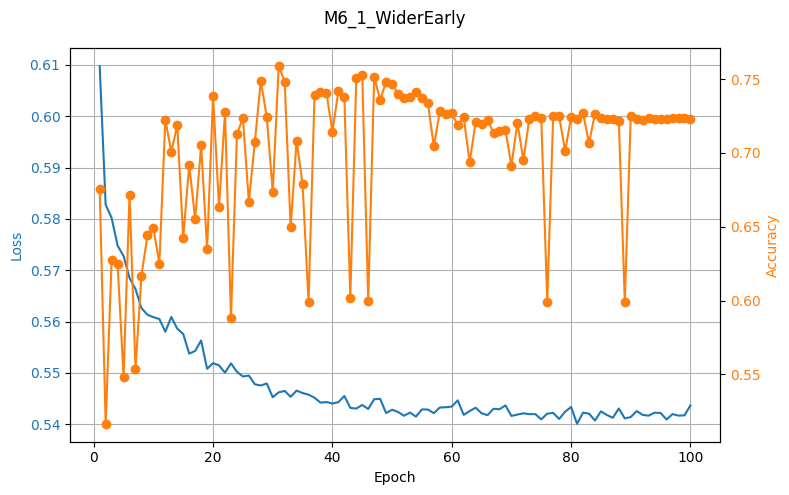

Model to test: M6_2_StrongerLate
feature_dim: 3072
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7663007ddab0>


Epoch 15/100 loss=0.5637 val_acc=0.6902 best=0.7566:  15%|▏| 15/100 [27:29<2:35:

Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/100 loss=0.5531 val_acc=0.6255 best=0.7566:  21%|▏| 21/100 [38:20<2:23:

Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


Epoch 27/100 loss=0.5488 val_acc=0.6047 best=0.7566:  27%|▎| 27/100 [49:18<2:13:

Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.


Epoch 33/100 loss=0.5461 val_acc=0.6250 best=0.7566:  33%|▎| 33/100 [1:00:13<2:0

Epoch 00033: reducing learning rate of group 0 to 6.2500e-05.


Epoch 43/100 loss=0.5436 val_acc=0.6277 best=0.7664:  43%|▍| 43/100 [1:18:24<1:4

Epoch 00043: reducing learning rate of group 0 to 3.1250e-05.


Epoch 49/100 loss=0.5434 val_acc=0.6294 best=0.7664:  49%|▍| 49/100 [1:29:22<1:3

Epoch 00049: reducing learning rate of group 0 to 1.5625e-05.


Epoch 55/100 loss=0.5438 val_acc=0.7664 best=0.7664:  55%|▌| 55/100 [1:40:18<1:2

Epoch 00055: reducing learning rate of group 0 to 7.8125e-06.


Epoch 61/100 loss=0.5430 val_acc=0.6255 best=0.7664:  61%|▌| 61/100 [1:51:17<1:1

Epoch 00061: reducing learning rate of group 0 to 3.9063e-06.


Epoch 67/100 loss=0.5417 val_acc=0.6277 best=0.7664:  67%|▋| 67/100 [2:02:14<1:0

Epoch 00067: reducing learning rate of group 0 to 1.9531e-06.


Epoch 73/100 loss=0.5431 val_acc=0.6283 best=0.7664:  73%|▋| 73/100 [2:13:10<49:

Epoch 00073: reducing learning rate of group 0 to 9.7656e-07.


Epoch 79/100 loss=0.5428 val_acc=0.6288 best=0.7664:  79%|▊| 79/100 [2:24:09<38:

Epoch 00079: reducing learning rate of group 0 to 4.8828e-07.


Epoch 85/100 loss=0.5418 val_acc=0.6283 best=0.7664:  85%|▊| 85/100 [2:35:02<27:

Epoch 00085: reducing learning rate of group 0 to 2.4414e-07.


Epoch 91/100 loss=0.5426 val_acc=0.6299 best=0.7664:  91%|▉| 91/100 [2:45:55<16:

Epoch 00091: reducing learning rate of group 0 to 1.2207e-07.


Epoch 97/100 loss=0.5411 val_acc=0.6299 best=0.7664:  97%|▉| 97/100 [2:56:48<05:

Epoch 00097: reducing learning rate of group 0 to 6.1035e-08.


Epoch 100/100 loss=0.5401 val_acc=0.7643 best=0.7664: 100%|█| 100/100 [3:02:16<0

Best val accuracy: 0.7664473684210527


Final TEST accuracy: 0.7733773377337734


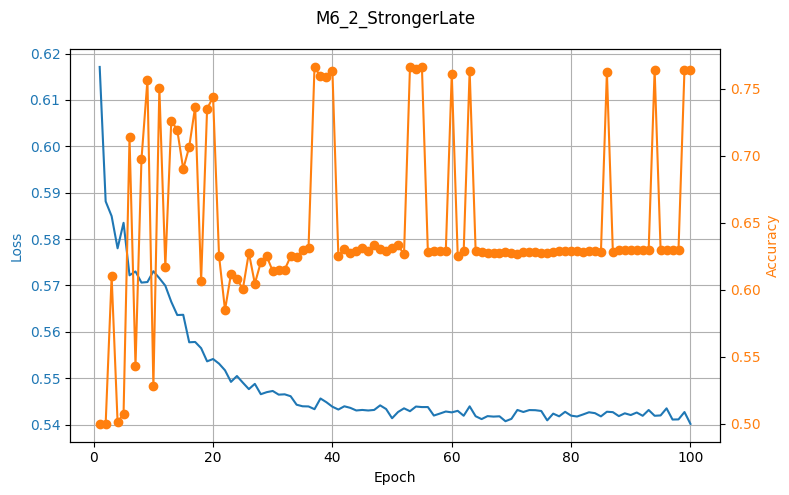

Model to test: M6_3_ExtraConvMid
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630aeb6ef0>


Epoch 14/100 loss=0.5691 val_acc=0.5669 best=0.7368:  14%|▏| 14/100 [31:01<3:08:

Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/100 loss=0.5598 val_acc=0.7039 best=0.7368:  20%|▏| 20/100 [42:11<2:34:

Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.


Epoch 26/100 loss=0.5554 val_acc=0.7155 best=0.7368:  26%|▎| 26/100 [53:52<2:24:

Epoch 00026: reducing learning rate of group 0 to 1.2500e-04.


Epoch 32/100 loss=0.5554 val_acc=0.7198 best=0.7368:  32%|▎| 32/100 [1:05:49<2:1

Epoch 00032: reducing learning rate of group 0 to 6.2500e-05.


Epoch 38/100 loss=0.5513 val_acc=0.6694 best=0.7368:  38%|▍| 38/100 [1:17:39<2:0

Epoch 00038: reducing learning rate of group 0 to 3.1250e-05.


Epoch 44/100 loss=0.5523 val_acc=0.6700 best=0.7368:  44%|▍| 44/100 [1:29:09<1:4

Epoch 00044: reducing learning rate of group 0 to 1.5625e-05.


Epoch 50/100 loss=0.5520 val_acc=0.6716 best=0.7368:  50%|▌| 50/100 [1:40:41<1:3

Epoch 00050: reducing learning rate of group 0 to 7.8125e-06.


Epoch 56/100 loss=0.5519 val_acc=0.6721 best=0.7368:  56%|▌| 56/100 [1:52:20<1:2

Epoch 00056: reducing learning rate of group 0 to 3.9063e-06.


Epoch 62/100 loss=0.5529 val_acc=0.7122 best=0.7368:  62%|▌| 62/100 [2:03:46<1:1

Epoch 00062: reducing learning rate of group 0 to 1.9531e-06.


Epoch 68/100 loss=0.5517 val_acc=0.7105 best=0.7368:  68%|▋| 68/100 [2:15:15<1:0

Epoch 00068: reducing learning rate of group 0 to 9.7656e-07.


Epoch 74/100 loss=0.5522 val_acc=0.7319 best=0.7368:  74%|▋| 74/100 [2:27:02<50:

Epoch 00074: reducing learning rate of group 0 to 4.8828e-07.


Epoch 80/100 loss=0.5507 val_acc=0.7336 best=0.7368:  80%|▊| 80/100 [2:38:47<39:

Epoch 00080: reducing learning rate of group 0 to 2.4414e-07.


Epoch 86/100 loss=0.5504 val_acc=0.7100 best=0.7368:  86%|▊| 86/100 [2:50:42<27:

Epoch 00086: reducing learning rate of group 0 to 1.2207e-07.


Epoch 92/100 loss=0.5518 val_acc=0.7116 best=0.7368:  92%|▉| 92/100 [3:02:14<15:

Epoch 00092: reducing learning rate of group 0 to 6.1035e-08.


Epoch 98/100 loss=0.5506 val_acc=0.7100 best=0.7368:  98%|▉| 98/100 [3:13:44<03:

Epoch 00098: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5510 val_acc=0.7116 best=0.7368: 100%|█| 100/100 [3:17:34<0

Best val accuracy: 0.7368421052631579


Final TEST accuracy: 0.7645764576457645


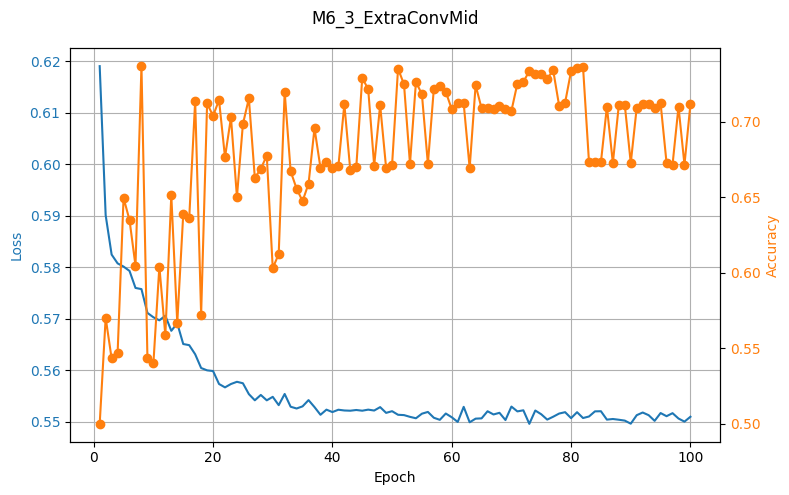

Model to test: M6_4_BiggerHead
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7663007de2c0>


Epoch 12/100 loss=0.5652 val_acc=0.5822 best=0.7357:  12%| | 12/100 [18:42<2:16:

Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/100 loss=0.5538 val_acc=0.6184 best=0.7357:  18%|▏| 18/100 [27:56<2:04:

Epoch 00018: reducing learning rate of group 0 to 2.5000e-04.


Epoch 28/100 loss=0.5470 val_acc=0.6595 best=0.7566:  28%|▎| 28/100 [43:09<1:49:

Epoch 00028: reducing learning rate of group 0 to 1.2500e-04.


Epoch 34/100 loss=0.5448 val_acc=0.6694 best=0.7566:  34%|▎| 34/100 [52:26<1:40:

Epoch 00034: reducing learning rate of group 0 to 6.2500e-05.


Epoch 40/100 loss=0.5419 val_acc=0.6886 best=0.7566:  40%|▍| 40/100 [1:01:43<1:3

Epoch 00040: reducing learning rate of group 0 to 3.1250e-05.


Epoch 46/100 loss=0.5413 val_acc=0.6985 best=0.7566:  46%|▍| 46/100 [1:10:50<1:2

Epoch 00046: reducing learning rate of group 0 to 1.5625e-05.


Epoch 52/100 loss=0.5426 val_acc=0.6902 best=0.7566:  52%|▌| 52/100 [1:19:50<1:1

Epoch 00052: reducing learning rate of group 0 to 7.8125e-06.


Epoch 58/100 loss=0.5407 val_acc=0.6700 best=0.7566:  58%|▌| 58/100 [1:28:38<59:

Epoch 00058: reducing learning rate of group 0 to 3.9063e-06.


Epoch 64/100 loss=0.5397 val_acc=0.6902 best=0.7566:  64%|▋| 64/100 [1:38:06<56:

Epoch 00064: reducing learning rate of group 0 to 1.9531e-06.


Epoch 70/100 loss=0.5402 val_acc=0.6913 best=0.7566:  70%|▋| 70/100 [1:47:44<47:

Epoch 00070: reducing learning rate of group 0 to 9.7656e-07.


Epoch 76/100 loss=0.5402 val_acc=0.6875 best=0.7566:  76%|▊| 76/100 [1:57:11<37:

Epoch 00076: reducing learning rate of group 0 to 4.8828e-07.


Epoch 82/100 loss=0.5403 val_acc=0.6902 best=0.7566:  82%|▊| 82/100 [2:06:42<28:

Epoch 00082: reducing learning rate of group 0 to 2.4414e-07.


Epoch 88/100 loss=0.5400 val_acc=0.6924 best=0.7566:  88%|▉| 88/100 [2:16:13<18:

Epoch 00088: reducing learning rate of group 0 to 1.2207e-07.


Epoch 94/100 loss=0.5405 val_acc=0.6891 best=0.7566:  94%|▉| 94/100 [2:25:43<09:

Epoch 00094: reducing learning rate of group 0 to 6.1035e-08.


Epoch 100/100 loss=0.5410 val_acc=0.6924 best=0.7566: 100%|█| 100/100 [2:35:32<0

Epoch 00100: reducing learning rate of group 0 to 3.0518e-08.
Best val accuracy: 0.756578947368421


Final TEST accuracy: 0.746974697469747


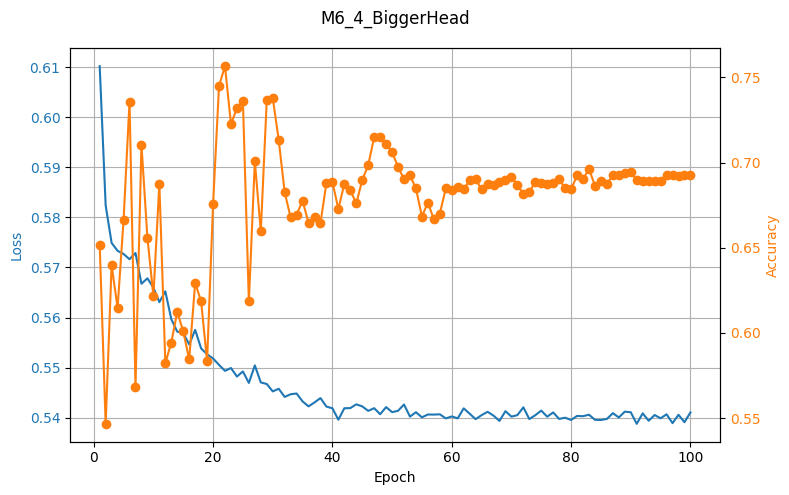

Model to test: M6_5_BottleneckMid
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630a730640>


Epoch 22/100 loss=0.5588 val_acc=0.5910 best=0.7346:  22%|▏| 22/100 [34:00<1:53:

Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.


Epoch 28/100 loss=0.5531 val_acc=0.5877 best=0.7346:  28%|▎| 28/100 [42:55<1:49:

Epoch 00028: reducing learning rate of group 0 to 2.5000e-04.


Epoch 34/100 loss=0.5498 val_acc=0.6129 best=0.7346:  34%|▎| 34/100 [52:24<1:43:

Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.


Epoch 40/100 loss=0.5450 val_acc=0.6201 best=0.7346:  40%|▍| 40/100 [1:01:53<1:3

Epoch 00040: reducing learning rate of group 0 to 6.2500e-05.


Epoch 46/100 loss=0.5463 val_acc=0.6239 best=0.7346:  46%|▍| 46/100 [1:11:21<1:2

Epoch 00046: reducing learning rate of group 0 to 3.1250e-05.


Epoch 52/100 loss=0.5445 val_acc=0.6234 best=0.7346:  52%|▌| 52/100 [1:20:52<1:1

Epoch 00052: reducing learning rate of group 0 to 1.5625e-05.


Epoch 58/100 loss=0.5461 val_acc=0.6223 best=0.7346:  58%|▌| 58/100 [1:30:22<1:0

Epoch 00058: reducing learning rate of group 0 to 7.8125e-06.


Epoch 64/100 loss=0.5463 val_acc=0.6239 best=0.7346:  64%|▋| 64/100 [1:39:43<56:

Epoch 00064: reducing learning rate of group 0 to 3.9063e-06.


Epoch 70/100 loss=0.5458 val_acc=0.6239 best=0.7346:  70%|▋| 70/100 [1:49:18<47:

Epoch 00070: reducing learning rate of group 0 to 1.9531e-06.


Epoch 76/100 loss=0.5462 val_acc=0.6239 best=0.7346:  76%|▊| 76/100 [1:58:11<34:

Epoch 00076: reducing learning rate of group 0 to 9.7656e-07.


Epoch 82/100 loss=0.5464 val_acc=0.6250 best=0.7346:  82%|▊| 82/100 [2:08:44<30:

Epoch 00082: reducing learning rate of group 0 to 4.8828e-07.


Epoch 88/100 loss=0.5437 val_acc=0.6234 best=0.7346:  88%|▉| 88/100 [2:19:08<20:

Epoch 00088: reducing learning rate of group 0 to 2.4414e-07.


Epoch 94/100 loss=0.5461 val_acc=0.6234 best=0.7346:  94%|▉| 94/100 [2:29:32<10:

Epoch 00094: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5469 val_acc=0.6201 best=0.7346: 100%|█| 100/100 [2:39:54<0

Epoch 00100: reducing learning rate of group 0 to 6.1035e-08.
Best val accuracy: 0.7346491228070176


Final TEST accuracy: 0.7414741474147415


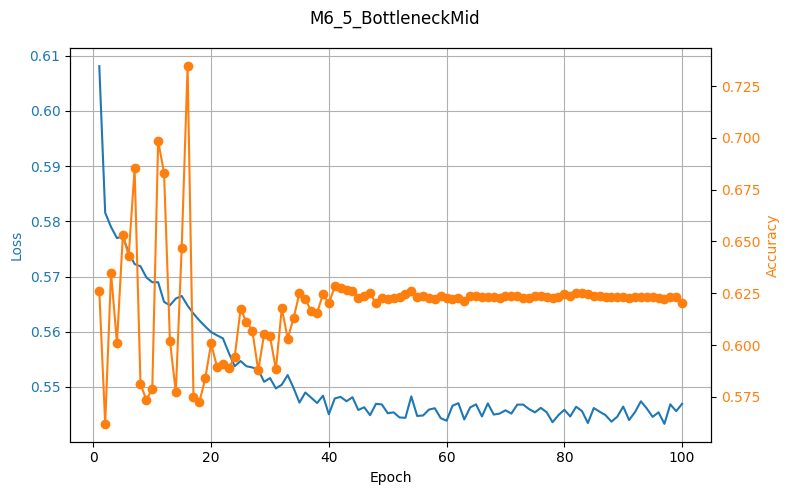

Model to test: M13_1_ExtraConvEarly
feature_dim: 16384
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630a6d2ef0>


Epoch 8/100 loss=0.5708 val_acc=0.5652 best=0.6190:   8%| | 8/100 [20:48<3:49:58

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 27/100 loss=0.5466 val_acc=0.6656 best=0.7538:  27%|▎| 27/100 [1:11:30<3:1

Epoch 00027: reducing learning rate of group 0 to 2.5000e-04.


Epoch 33/100 loss=0.5403 val_acc=0.7434 best=0.7538:  33%|▎| 33/100 [1:28:47<3:1

Epoch 00033: reducing learning rate of group 0 to 1.2500e-04.


Epoch 42/100 loss=0.5342 val_acc=0.6771 best=0.7560:  42%|▍| 42/100 [1:54:46<2:4

Epoch 00042: reducing learning rate of group 0 to 6.2500e-05.


Epoch 48/100 loss=0.5339 val_acc=0.7133 best=0.7560:  48%|▍| 48/100 [2:12:01<2:2

Epoch 00048: reducing learning rate of group 0 to 3.1250e-05.


Epoch 54/100 loss=0.5315 val_acc=0.6157 best=0.7560:  54%|▌| 54/100 [2:29:16<2:1

Epoch 00054: reducing learning rate of group 0 to 1.5625e-05.


Epoch 60/100 loss=0.5306 val_acc=0.6902 best=0.7560:  60%|▌| 60/100 [2:46:26<1:5

Epoch 00060: reducing learning rate of group 0 to 7.8125e-06.


Epoch 66/100 loss=0.5296 val_acc=0.6886 best=0.7560:  66%|▋| 66/100 [3:03:47<1:3

Epoch 00066: reducing learning rate of group 0 to 3.9063e-06.


Epoch 72/100 loss=0.5310 val_acc=0.6875 best=0.7560:  72%|▋| 72/100 [3:21:06<1:2

Epoch 00072: reducing learning rate of group 0 to 1.9531e-06.


Epoch 78/100 loss=0.5288 val_acc=0.6880 best=0.7560:  78%|▊| 78/100 [3:38:27<1:0

Epoch 00078: reducing learning rate of group 0 to 9.7656e-07.


Epoch 84/100 loss=0.5293 val_acc=0.6853 best=0.7560:  84%|▊| 84/100 [3:55:51<46:

Epoch 00084: reducing learning rate of group 0 to 4.8828e-07.


Epoch 90/100 loss=0.5307 val_acc=0.6864 best=0.7560:  90%|▉| 90/100 [4:13:13<28:

Epoch 00090: reducing learning rate of group 0 to 2.4414e-07.


Epoch 96/100 loss=0.5310 val_acc=0.6848 best=0.7560:  96%|▉| 96/100 [4:30:44<11:

Epoch 00096: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5303 val_acc=0.6848 best=0.7560: 100%|█| 100/100 [4:42:41<0

Best val accuracy: 0.7560307017543859


Final TEST accuracy: 0.7623762376237624


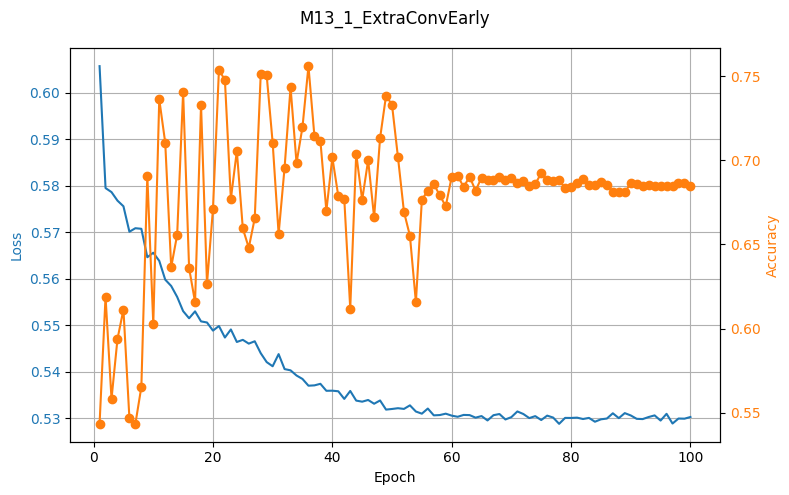

Model to test: M13_2_Wider
feature_dim: 20480
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630a786e30>


Epoch 13/100 loss=0.5503 val_acc=0.6409 best=0.6891:  13%|▏| 13/100 [31:00<3:25:

Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/100 loss=0.5405 val_acc=0.6316 best=0.6891:  19%|▏| 19/100 [45:05<3:14:

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Epoch 28/100 loss=0.5323 val_acc=0.6140 best=0.7747:  28%|▎| 28/100 [1:07:20<3:0

Epoch 00028: reducing learning rate of group 0 to 1.2500e-04.


Epoch 34/100 loss=0.5264 val_acc=0.6360 best=0.7747:  34%|▎| 34/100 [1:22:49<2:5

Epoch 00034: reducing learning rate of group 0 to 6.2500e-05.


Epoch 40/100 loss=0.5250 val_acc=0.6338 best=0.7747:  40%|▍| 40/100 [1:38:11<2:3

Epoch 00040: reducing learning rate of group 0 to 3.1250e-05.


Epoch 46/100 loss=0.5215 val_acc=0.6327 best=0.7747:  46%|▍| 46/100 [1:53:45<2:2

Epoch 00046: reducing learning rate of group 0 to 1.5625e-05.


Epoch 52/100 loss=0.5211 val_acc=0.6338 best=0.7747:  52%|▌| 52/100 [2:09:16<2:0

Epoch 00052: reducing learning rate of group 0 to 7.8125e-06.


Epoch 58/100 loss=0.5187 val_acc=0.6184 best=0.7747:  58%|▌| 58/100 [2:24:39<1:4

Epoch 00058: reducing learning rate of group 0 to 3.9063e-06.


Epoch 64/100 loss=0.5196 val_acc=0.6349 best=0.7747:  64%|▋| 64/100 [2:40:06<1:3

Epoch 00064: reducing learning rate of group 0 to 1.9531e-06.


Epoch 70/100 loss=0.5184 val_acc=0.6332 best=0.7747:  70%|▋| 70/100 [2:55:34<1:1

Epoch 00070: reducing learning rate of group 0 to 9.7656e-07.


Epoch 76/100 loss=0.5186 val_acc=0.6354 best=0.7747:  76%|▊| 76/100 [3:10:29<58:

Epoch 00076: reducing learning rate of group 0 to 4.8828e-07.


Epoch 82/100 loss=0.5203 val_acc=0.6354 best=0.7747:  82%|▊| 82/100 [3:24:37<41:

Epoch 00082: reducing learning rate of group 0 to 2.4414e-07.


Epoch 88/100 loss=0.5192 val_acc=0.6365 best=0.7747:  88%|▉| 88/100 [3:40:05<30:

Epoch 00088: reducing learning rate of group 0 to 1.2207e-07.


Epoch 94/100 loss=0.5180 val_acc=0.6371 best=0.7747:  94%|▉| 94/100 [3:55:49<15:

Epoch 00094: reducing learning rate of group 0 to 6.1035e-08.


Epoch 100/100 loss=0.5181 val_acc=0.6365 best=0.7747: 100%|█| 100/100 [4:11:30<0

Epoch 00100: reducing learning rate of group 0 to 3.0518e-08.
Best val accuracy: 0.774671052631579


Final TEST accuracy: 0.7865786578657866


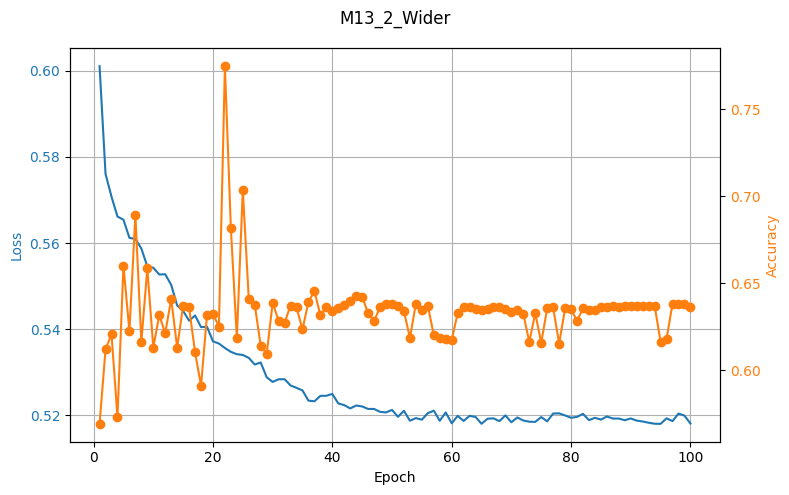

Model to test: M13_3_Extra1x1Late
feature_dim: 16384
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630af586a0>


Epoch 7/100 loss=0.5711 val_acc=0.6908 best=0.7198:   7%| | 7/100 [17:17<3:42:25

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 25/100 loss=0.5444 val_acc=0.7549 best=0.7769:  25%|▎| 25/100 [59:48<3:03:

Epoch 00025: reducing learning rate of group 0 to 2.5000e-04.


Epoch 42/100 loss=0.5309 val_acc=0.7917 best=0.8048:  42%|▍| 42/100 [1:41:33<2:2

Epoch 00042: reducing learning rate of group 0 to 1.2500e-04.


Epoch 48/100 loss=0.5263 val_acc=0.7791 best=0.8048:  48%|▍| 48/100 [1:56:20<2:0

Epoch 00048: reducing learning rate of group 0 to 6.2500e-05.


Epoch 54/100 loss=0.5235 val_acc=0.7911 best=0.8048:  54%|▌| 54/100 [2:10:57<1:5

Epoch 00054: reducing learning rate of group 0 to 3.1250e-05.


Epoch 60/100 loss=0.5230 val_acc=0.7862 best=0.8048:  60%|▌| 60/100 [2:25:38<1:3

Epoch 00060: reducing learning rate of group 0 to 1.5625e-05.


Epoch 66/100 loss=0.5208 val_acc=0.7900 best=0.8048:  66%|▋| 66/100 [2:40:23<1:2

Epoch 00066: reducing learning rate of group 0 to 7.8125e-06.


Epoch 72/100 loss=0.5201 val_acc=0.7900 best=0.8048:  72%|▋| 72/100 [2:55:01<1:0

Epoch 00072: reducing learning rate of group 0 to 3.9063e-06.


Epoch 78/100 loss=0.5196 val_acc=0.7922 best=0.8048:  78%|▊| 78/100 [3:08:03<50:

Epoch 00078: reducing learning rate of group 0 to 1.9531e-06.


Epoch 84/100 loss=0.5199 val_acc=0.7922 best=0.8048:  84%|▊| 84/100 [3:22:42<38:

Epoch 00084: reducing learning rate of group 0 to 9.7656e-07.


Epoch 90/100 loss=0.5184 val_acc=0.7900 best=0.8048:  90%|▉| 90/100 [3:37:23<24:

Epoch 00090: reducing learning rate of group 0 to 4.8828e-07.


Epoch 96/100 loss=0.5198 val_acc=0.7917 best=0.8048:  96%|▉| 96/100 [3:52:26<10:

Epoch 00096: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5193 val_acc=0.7884 best=0.8048: 100%|█| 100/100 [4:02:35<0

Best val accuracy: 0.8048245614035088


Final TEST accuracy: 0.8063806380638063


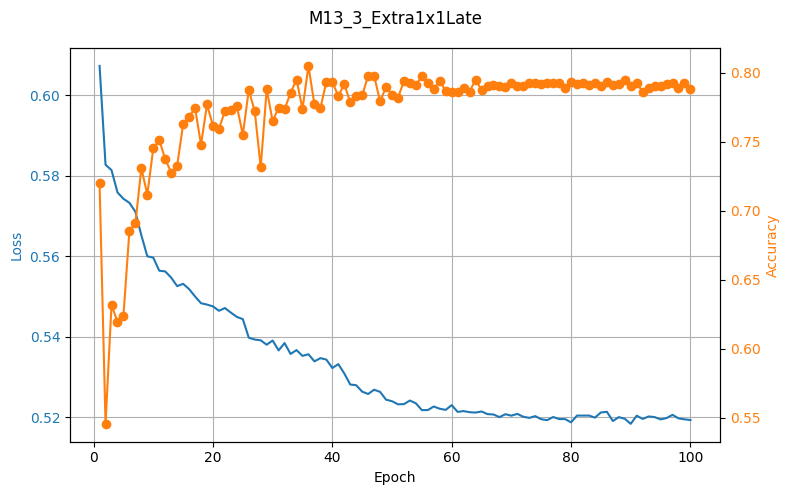

Model to test: M13_4_MorePoolBiggerFC
feature_dim: 4096
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630aeb64a0>


Epoch 10/100 loss=0.5563 val_acc=0.5811 best=0.7182:  10%| | 10/100 [23:32<3:30:

Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.


Epoch 29/100 loss=0.5399 val_acc=0.7445 best=0.7928:  29%|▎| 29/100 [1:05:01<2:3

Epoch 00029: reducing learning rate of group 0 to 2.5000e-04.


Epoch 35/100 loss=0.5332 val_acc=0.7823 best=0.7928:  35%|▎| 35/100 [1:18:06<2:2

Epoch 00035: reducing learning rate of group 0 to 1.2500e-04.


Epoch 41/100 loss=0.5280 val_acc=0.7719 best=0.7928:  41%|▍| 41/100 [1:31:09<2:0

Epoch 00041: reducing learning rate of group 0 to 6.2500e-05.


Epoch 47/100 loss=0.5247 val_acc=0.7681 best=0.7928:  47%|▍| 47/100 [1:44:07<1:5

Epoch 00047: reducing learning rate of group 0 to 3.1250e-05.


Epoch 53/100 loss=0.5233 val_acc=0.7802 best=0.7928:  53%|▌| 53/100 [1:57:07<1:4

Epoch 00053: reducing learning rate of group 0 to 1.5625e-05.


Epoch 59/100 loss=0.5226 val_acc=0.7741 best=0.7928:  59%|▌| 59/100 [2:10:07<1:2

Epoch 00059: reducing learning rate of group 0 to 7.8125e-06.


Epoch 65/100 loss=0.5209 val_acc=0.7845 best=0.7928:  65%|▋| 65/100 [2:23:12<1:1

Epoch 00065: reducing learning rate of group 0 to 3.9063e-06.


Epoch 71/100 loss=0.5221 val_acc=0.7654 best=0.7928:  71%|▋| 71/100 [2:36:22<1:0

Epoch 00071: reducing learning rate of group 0 to 1.9531e-06.


Epoch 77/100 loss=0.5217 val_acc=0.7845 best=0.7928:  77%|▊| 77/100 [2:49:24<50:

Epoch 00077: reducing learning rate of group 0 to 9.7656e-07.


Epoch 83/100 loss=0.5215 val_acc=0.7818 best=0.7928:  83%|▊| 83/100 [3:02:22<36:

Epoch 00083: reducing learning rate of group 0 to 4.8828e-07.


Epoch 89/100 loss=0.5219 val_acc=0.7823 best=0.7928:  89%|▉| 89/100 [3:15:30<24:

Epoch 00089: reducing learning rate of group 0 to 2.4414e-07.


Epoch 95/100 loss=0.5209 val_acc=0.7818 best=0.7928:  95%|▉| 95/100 [3:28:33<10:

Epoch 00095: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5211 val_acc=0.7823 best=0.7928: 100%|█| 100/100 [3:39:36<0

Best val accuracy: 0.7927631578947368


Final TEST accuracy: 0.7865786578657866


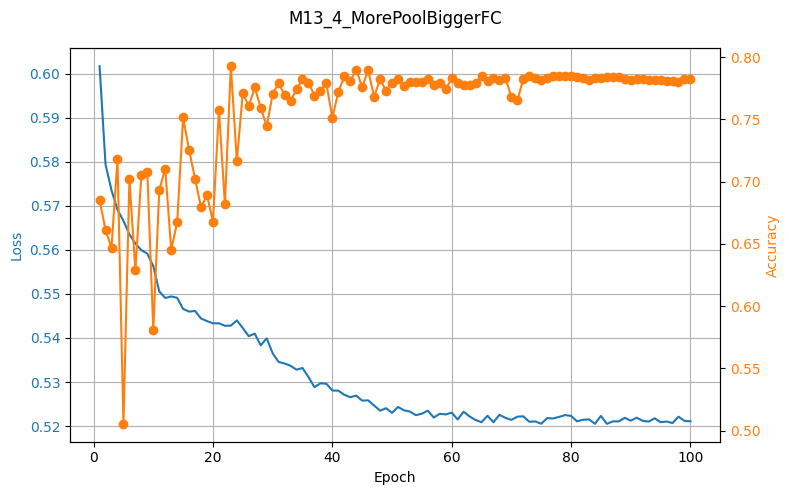

Model to test: M13_5_WithDropout
feature_dim: 16384
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630a7548b0>


Epoch 8/100 loss=0.5561 val_acc=0.6957 best=0.7467:   8%| | 8/100 [18:46<3:33:26

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 14/100 loss=0.5469 val_acc=0.6404 best=0.7467:  14%|▏| 14/100 [32:29<3:17:

Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.


Epoch 24/100 loss=0.5386 val_acc=0.7259 best=0.7582:  24%|▏| 24/100 [55:17<2:53:

Epoch 00024: reducing learning rate of group 0 to 1.2500e-04.


Epoch 30/100 loss=0.5333 val_acc=0.7412 best=0.7582:  30%|▎| 30/100 [1:09:05<2:4

Epoch 00030: reducing learning rate of group 0 to 6.2500e-05.


Epoch 36/100 loss=0.5295 val_acc=0.6573 best=0.7582:  36%|▎| 36/100 [1:22:44<2:2

Epoch 00036: reducing learning rate of group 0 to 3.1250e-05.


Epoch 42/100 loss=0.5292 val_acc=0.6535 best=0.7582:  42%|▍| 42/100 [1:36:32<2:1

Epoch 00042: reducing learning rate of group 0 to 1.5625e-05.


Epoch 48/100 loss=0.5282 val_acc=0.7308 best=0.7582:  48%|▍| 48/100 [1:50:12<1:5

Epoch 00048: reducing learning rate of group 0 to 7.8125e-06.


Epoch 54/100 loss=0.5293 val_acc=0.7303 best=0.7582:  54%|▌| 54/100 [2:03:25<1:3

Epoch 00054: reducing learning rate of group 0 to 3.9063e-06.


Epoch 60/100 loss=0.5288 val_acc=0.7319 best=0.7582:  60%|▌| 60/100 [2:17:11<1:3

Epoch 00060: reducing learning rate of group 0 to 1.9531e-06.


Epoch 66/100 loss=0.5268 val_acc=0.7292 best=0.7582:  66%|▋| 66/100 [2:30:54<1:1

Epoch 00066: reducing learning rate of group 0 to 9.7656e-07.


Epoch 72/100 loss=0.5272 val_acc=0.7286 best=0.7582:  72%|▋| 72/100 [2:44:38<1:0

Epoch 00072: reducing learning rate of group 0 to 4.8828e-07.


Epoch 78/100 loss=0.5274 val_acc=0.7281 best=0.7582:  78%|▊| 78/100 [2:58:28<50:

Epoch 00078: reducing learning rate of group 0 to 2.4414e-07.


Epoch 84/100 loss=0.5294 val_acc=0.7281 best=0.7582:  84%|▊| 84/100 [3:12:22<37:

Epoch 00084: reducing learning rate of group 0 to 1.2207e-07.


Epoch 90/100 loss=0.5281 val_acc=0.7275 best=0.7582:  90%|▉| 90/100 [3:25:31<22:

Epoch 00090: reducing learning rate of group 0 to 6.1035e-08.


Epoch 96/100 loss=0.5268 val_acc=0.7275 best=0.7582:  96%|▉| 96/100 [3:38:42<09:

Epoch 00096: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5275 val_acc=0.7275 best=0.7582: 100%|█| 100/100 [3:48:08<0

Best val accuracy: 0.7582236842105263


Final TEST accuracy: 0.7557755775577558


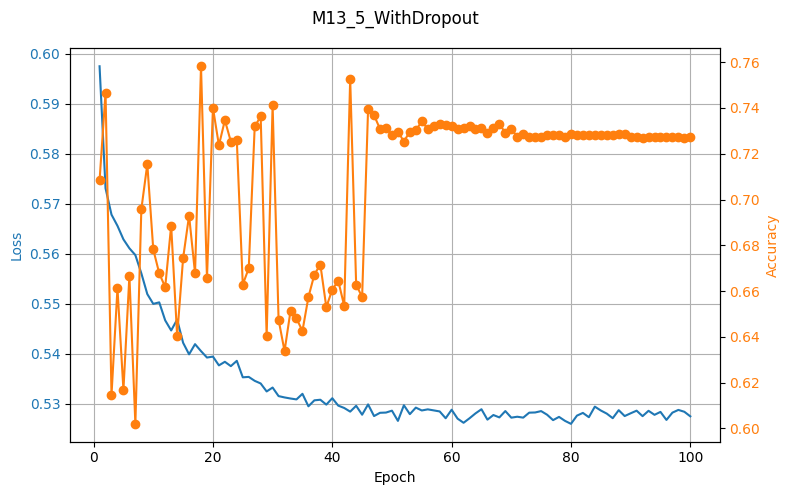

Model to test: M19_1_SlightlyWider
feature_dim: 1920
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630af58970>


Epoch 8/100 loss=0.5666 val_acc=0.5565 best=0.6705:   8%| | 8/100 [13:46<2:36:17

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/100 loss=0.5533 val_acc=0.6864 best=0.7094:  19%|▏| 19/100 [32:36<2:19:

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Epoch 29/100 loss=0.5450 val_acc=0.6738 best=0.7127:  29%|▎| 29/100 [49:43<2:01:

Epoch 00029: reducing learning rate of group 0 to 1.2500e-04.


Epoch 35/100 loss=0.5412 val_acc=0.6096 best=0.7127:  35%|▎| 35/100 [1:00:00<1:5

Epoch 00035: reducing learning rate of group 0 to 6.2500e-05.


Epoch 41/100 loss=0.5381 val_acc=0.6146 best=0.7127:  41%|▍| 41/100 [1:10:14<1:4

Epoch 00041: reducing learning rate of group 0 to 3.1250e-05.


Epoch 47/100 loss=0.5379 val_acc=0.6124 best=0.7127:  47%|▍| 47/100 [1:20:26<1:3

Epoch 00047: reducing learning rate of group 0 to 1.5625e-05.


Epoch 53/100 loss=0.5377 val_acc=0.6173 best=0.7127:  53%|▌| 53/100 [1:30:46<1:2

Epoch 00053: reducing learning rate of group 0 to 7.8125e-06.


Epoch 59/100 loss=0.5374 val_acc=0.6212 best=0.7127:  59%|▌| 59/100 [1:41:02<1:1

Epoch 00059: reducing learning rate of group 0 to 3.9063e-06.


Epoch 65/100 loss=0.5381 val_acc=0.6217 best=0.7127:  65%|▋| 65/100 [1:51:17<59:

Epoch 00065: reducing learning rate of group 0 to 1.9531e-06.


Epoch 71/100 loss=0.5390 val_acc=0.6277 best=0.7127:  71%|▋| 71/100 [2:01:44<50:

Epoch 00071: reducing learning rate of group 0 to 9.7656e-07.


Epoch 77/100 loss=0.5376 val_acc=0.6212 best=0.7127:  77%|▊| 77/100 [2:12:00<39:

Epoch 00077: reducing learning rate of group 0 to 4.8828e-07.


Epoch 83/100 loss=0.5376 val_acc=0.6075 best=0.7127:  83%|▊| 83/100 [2:22:14<28:

Epoch 00083: reducing learning rate of group 0 to 2.4414e-07.


Epoch 89/100 loss=0.5382 val_acc=0.6212 best=0.7127:  89%|▉| 89/100 [2:32:40<19:

Epoch 00089: reducing learning rate of group 0 to 1.2207e-07.


Epoch 95/100 loss=0.5363 val_acc=0.6206 best=0.7127:  95%|▉| 95/100 [2:42:50<08:

Epoch 00095: reducing learning rate of group 0 to 6.1035e-08.


Epoch 100/100 loss=0.5372 val_acc=0.6212 best=0.7127: 100%|█| 100/100 [2:51:27<0

Best val accuracy: 0.7127192982456141


Final TEST accuracy: 0.6908690869086909


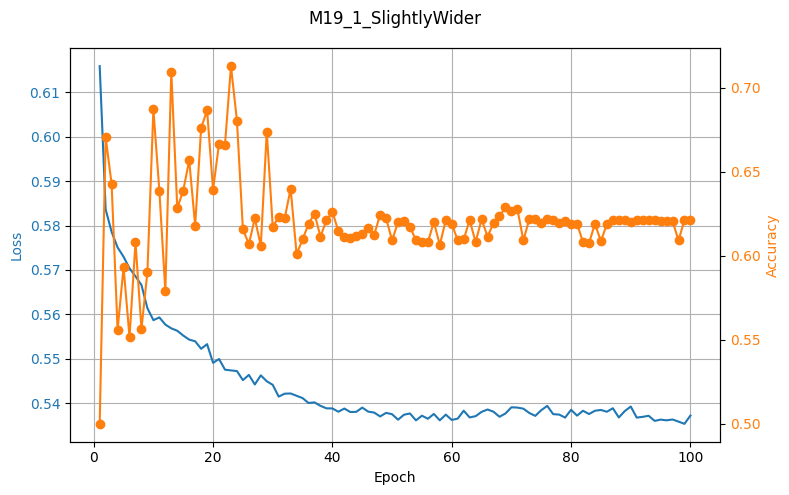

Model to test: M19_2_LastTo32
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630aefcbe0>


Epoch 9/100 loss=0.5636 val_acc=0.5806 best=0.7527:   9%| | 9/100 [13:15<2:11:51

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/100 loss=0.5531 val_acc=0.7390 best=0.7527:  15%|▏| 15/100 [21:54<2:03:

Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.


Epoch 23/100 loss=0.5458 val_acc=0.6519 best=0.7834:  23%|▏| 23/100 [33:32<1:52:

Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


Epoch 29/100 loss=0.5430 val_acc=0.6661 best=0.7834:  29%|▎| 29/100 [42:07<1:41:

Epoch 00029: reducing learning rate of group 0 to 6.2500e-05.


Epoch 35/100 loss=0.5401 val_acc=0.7138 best=0.7834:  35%|▎| 35/100 [50:46<1:33:

Epoch 00035: reducing learning rate of group 0 to 3.1250e-05.


Epoch 41/100 loss=0.5379 val_acc=0.7089 best=0.7834:  41%|▍| 41/100 [59:23<1:24:

Epoch 00041: reducing learning rate of group 0 to 1.5625e-05.


Epoch 47/100 loss=0.5376 val_acc=0.7198 best=0.7834:  47%|▍| 47/100 [1:08:06<1:1

Epoch 00047: reducing learning rate of group 0 to 7.8125e-06.


Epoch 53/100 loss=0.5393 val_acc=0.7089 best=0.7834:  53%|▌| 53/100 [1:16:44<1:0

Epoch 00053: reducing learning rate of group 0 to 3.9063e-06.


Epoch 59/100 loss=0.5371 val_acc=0.6826 best=0.7834:  59%|▌| 59/100 [1:25:22<58:

Epoch 00059: reducing learning rate of group 0 to 1.9531e-06.


Epoch 65/100 loss=0.5391 val_acc=0.6831 best=0.7834:  65%|▋| 65/100 [1:33:58<49:

Epoch 00065: reducing learning rate of group 0 to 9.7656e-07.


Epoch 71/100 loss=0.5373 val_acc=0.6787 best=0.7834:  71%|▋| 71/100 [1:42:38<41:

Epoch 00071: reducing learning rate of group 0 to 4.8828e-07.


Epoch 77/100 loss=0.5362 val_acc=0.6919 best=0.7834:  77%|▊| 77/100 [1:51:23<33:

Epoch 00077: reducing learning rate of group 0 to 2.4414e-07.


Epoch 83/100 loss=0.5362 val_acc=0.6798 best=0.7834:  83%|▊| 83/100 [2:00:03<24:

Epoch 00083: reducing learning rate of group 0 to 1.2207e-07.


Epoch 89/100 loss=0.5362 val_acc=0.6732 best=0.7834:  89%|▉| 89/100 [2:08:47<16:

Epoch 00089: reducing learning rate of group 0 to 6.1035e-08.


Epoch 95/100 loss=0.5372 val_acc=0.6891 best=0.7834:  95%|▉| 95/100 [2:17:24<07:

Epoch 00095: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5366 val_acc=0.6864 best=0.7834: 100%|█| 100/100 [2:24:39<0

Best val accuracy: 0.7834429824561403


Final TEST accuracy: 0.7799779977997799


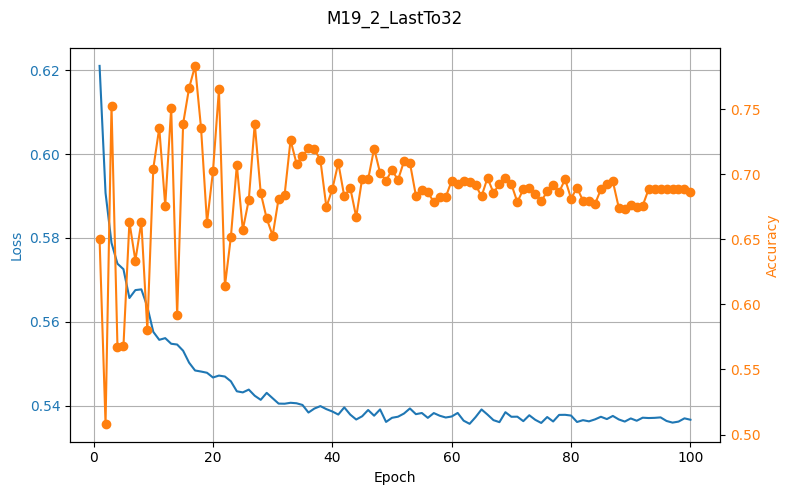

Model to test: M19_3_ExtraConvMid
feature_dim: 1536
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630aeb6e00>


Epoch 22/100 loss=0.5581 val_acc=0.5652 best=0.7368:  22%|▏| 22/100 [38:36<2:16:

Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.


Epoch 28/100 loss=0.5500 val_acc=0.7325 best=0.7368:  28%|▎| 28/100 [49:09<2:05:

Epoch 00028: reducing learning rate of group 0 to 2.5000e-04.


Epoch 34/100 loss=0.5452 val_acc=0.7133 best=0.7368:  34%|▎| 34/100 [59:41<1:55:

Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.


Epoch 42/100 loss=0.5401 val_acc=0.7018 best=0.7604:  42%|▍| 42/100 [1:13:03<1:3

Epoch 00042: reducing learning rate of group 0 to 6.2500e-05.


Epoch 48/100 loss=0.5389 val_acc=0.6957 best=0.7604:  48%|▍| 48/100 [1:22:58<1:2

Epoch 00048: reducing learning rate of group 0 to 3.1250e-05.


Epoch 54/100 loss=0.5386 val_acc=0.7094 best=0.7604:  54%|▌| 54/100 [1:32:41<1:1

Epoch 00054: reducing learning rate of group 0 to 1.5625e-05.


Epoch 60/100 loss=0.5379 val_acc=0.7056 best=0.7604:  60%|▌| 60/100 [1:43:13<1:0

Epoch 00060: reducing learning rate of group 0 to 7.8125e-06.


Epoch 66/100 loss=0.5385 val_acc=0.7072 best=0.7604:  66%|▋| 66/100 [1:53:44<59:

Epoch 00066: reducing learning rate of group 0 to 3.9063e-06.


Epoch 72/100 loss=0.5368 val_acc=0.6924 best=0.7604:  72%|▋| 72/100 [2:04:14<49:

Epoch 00072: reducing learning rate of group 0 to 1.9531e-06.


Epoch 78/100 loss=0.5373 val_acc=0.7001 best=0.7604:  78%|▊| 78/100 [2:14:47<38:

Epoch 00078: reducing learning rate of group 0 to 9.7656e-07.


Epoch 84/100 loss=0.5373 val_acc=0.6952 best=0.7604:  84%|▊| 84/100 [2:25:19<28:

Epoch 00084: reducing learning rate of group 0 to 4.8828e-07.


Epoch 90/100 loss=0.5363 val_acc=0.6935 best=0.7604:  90%|▉| 90/100 [2:35:49<17:

Epoch 00090: reducing learning rate of group 0 to 2.4414e-07.


Epoch 96/100 loss=0.5369 val_acc=0.6919 best=0.7604:  96%|▉| 96/100 [2:46:19<07:

Epoch 00096: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5376 val_acc=0.6968 best=0.7604: 100%|█| 100/100 [2:53:20<0

Best val accuracy: 0.7604166666666666


Final TEST accuracy: 0.7601760176017601


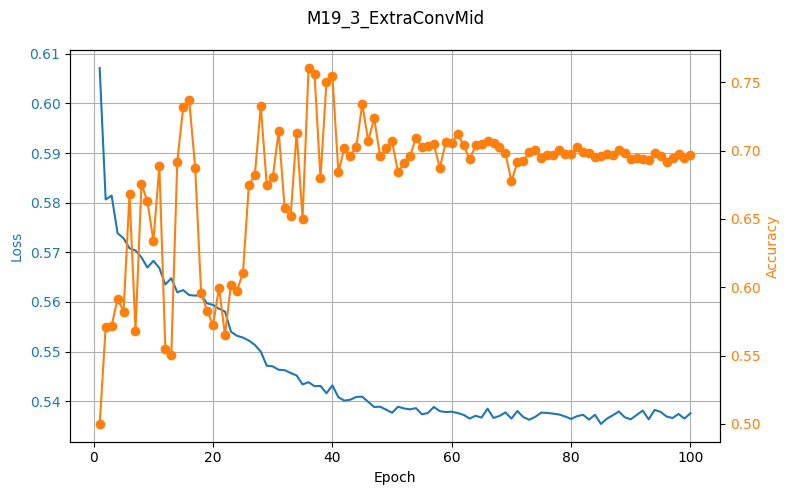

Model to test: M19_4_BottleneckBeforeC3
feature_dim: 1536
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630aee4af0>


Epoch 8/100 loss=0.5708 val_acc=0.6025 best=0.6732:   8%| | 8/100 [12:10<2:18:36

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/100 loss=0.5615 val_acc=0.5998 best=0.7007:  16%|▏| 16/100 [24:18<2:07:

Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.


Epoch 22/100 loss=0.5576 val_acc=0.6584 best=0.7007:  22%|▏| 22/100 [33:26<1:59:

Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.


Epoch 33/100 loss=0.5539 val_acc=0.6859 best=0.7171:  33%|▎| 33/100 [50:09<1:41:

Epoch 00033: reducing learning rate of group 0 to 6.2500e-05.


Epoch 39/100 loss=0.5530 val_acc=0.6985 best=0.7171:  39%|▍| 39/100 [59:18<1:32:

Epoch 00039: reducing learning rate of group 0 to 3.1250e-05.


Epoch 45/100 loss=0.5513 val_acc=0.6826 best=0.7171:  45%|▍| 45/100 [1:08:23<1:2

Epoch 00045: reducing learning rate of group 0 to 1.5625e-05.


Epoch 51/100 loss=0.5526 val_acc=0.6820 best=0.7171:  51%|▌| 51/100 [1:17:29<1:1

Epoch 00051: reducing learning rate of group 0 to 7.8125e-06.


Epoch 57/100 loss=0.5519 val_acc=0.6870 best=0.7171:  57%|▌| 57/100 [1:26:38<1:0

Epoch 00057: reducing learning rate of group 0 to 3.9063e-06.


Epoch 63/100 loss=0.5507 val_acc=0.6765 best=0.7171:  63%|▋| 63/100 [1:35:37<55:

Epoch 00063: reducing learning rate of group 0 to 1.9531e-06.


Epoch 69/100 loss=0.5519 val_acc=0.6831 best=0.7171:  69%|▋| 69/100 [1:44:39<46:

Epoch 00069: reducing learning rate of group 0 to 9.7656e-07.


Epoch 75/100 loss=0.5526 val_acc=0.6859 best=0.7171:  75%|▊| 75/100 [1:53:45<37:

Epoch 00075: reducing learning rate of group 0 to 4.8828e-07.


Epoch 81/100 loss=0.5503 val_acc=0.6853 best=0.7171:  81%|▊| 81/100 [2:02:50<28:

Epoch 00081: reducing learning rate of group 0 to 2.4414e-07.


Epoch 87/100 loss=0.5517 val_acc=0.6859 best=0.7171:  87%|▊| 87/100 [2:12:02<20:

Epoch 00087: reducing learning rate of group 0 to 1.2207e-07.


Epoch 93/100 loss=0.5518 val_acc=0.6760 best=0.7171:  93%|▉| 93/100 [2:21:09<10:

Epoch 00093: reducing learning rate of group 0 to 6.1035e-08.


Epoch 99/100 loss=0.5526 val_acc=0.6831 best=0.7171:  99%|▉| 99/100 [2:29:51<01:

Epoch 00099: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5514 val_acc=0.6919 best=0.7171: 100%|█| 100/100 [2:31:05<0

Best val accuracy: 0.7171052631578947


Final TEST accuracy: 0.7194719471947195


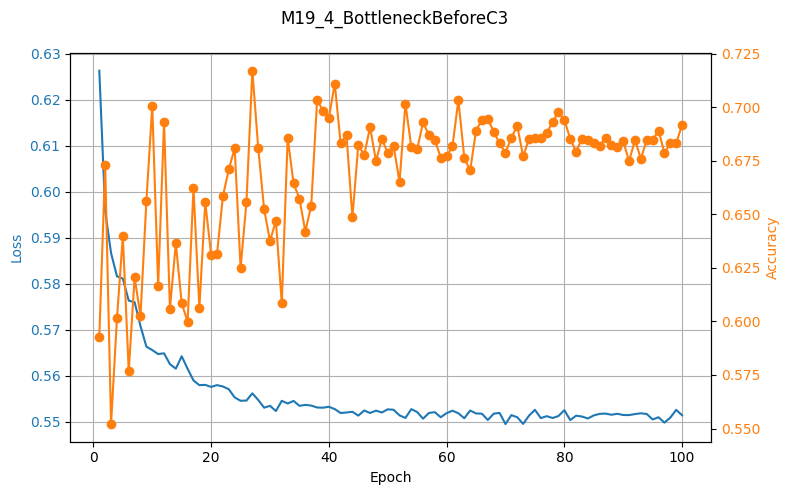

Model to test: M19_5_BiggerHead
feature_dim: 1536
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76630aeff6a0>


Epoch 7/100 loss=0.5726 val_acc=0.5510 best=0.6118:   7%| | 7/100 [10:25<2:11:36

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 32/100 loss=0.5524 val_acc=0.7401 best=0.7467:  32%|▎| 32/100 [48:31<1:44:

Epoch 00032: reducing learning rate of group 0 to 2.5000e-04.


Epoch 41/100 loss=0.5469 val_acc=0.7039 best=0.7555:  41%|▍| 41/100 [1:02:26<1:2

Epoch 00041: reducing learning rate of group 0 to 1.2500e-04.


Epoch 47/100 loss=0.5433 val_acc=0.7445 best=0.7555:  47%|▍| 47/100 [1:11:47<1:2

Epoch 00047: reducing learning rate of group 0 to 6.2500e-05.


Epoch 53/100 loss=0.5418 val_acc=0.6870 best=0.7555:  53%|▌| 53/100 [1:21:07<1:1

Epoch 00053: reducing learning rate of group 0 to 3.1250e-05.


Epoch 59/100 loss=0.5409 val_acc=0.7330 best=0.7555:  59%|▌| 59/100 [1:30:47<1:0

Epoch 00059: reducing learning rate of group 0 to 1.5625e-05.


Epoch 65/100 loss=0.5395 val_acc=0.6837 best=0.7555:  65%|▋| 65/100 [1:40:13<55:

Epoch 00065: reducing learning rate of group 0 to 7.8125e-06.


Epoch 71/100 loss=0.5400 val_acc=0.6853 best=0.7555:  71%|▋| 71/100 [1:49:30<44:

Epoch 00071: reducing learning rate of group 0 to 3.9063e-06.


Epoch 77/100 loss=0.5380 val_acc=0.6864 best=0.7555:  77%|▊| 77/100 [1:58:56<35:

Epoch 00077: reducing learning rate of group 0 to 1.9531e-06.


Epoch 83/100 loss=0.5392 val_acc=0.6870 best=0.7555:  83%|▊| 83/100 [2:08:20<26:

Epoch 00083: reducing learning rate of group 0 to 9.7656e-07.


Epoch 89/100 loss=0.5400 val_acc=0.6837 best=0.7555:  89%|▉| 89/100 [2:17:47<17:

Epoch 00089: reducing learning rate of group 0 to 4.8828e-07.


Epoch 95/100 loss=0.5410 val_acc=0.7198 best=0.7555:  95%|▉| 95/100 [2:27:07<07:

Epoch 00095: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5399 val_acc=0.6848 best=0.7555: 100%|█| 100/100 [2:35:00<0

Best val accuracy: 0.7554824561403509


Final TEST accuracy: 0.7645764576457645


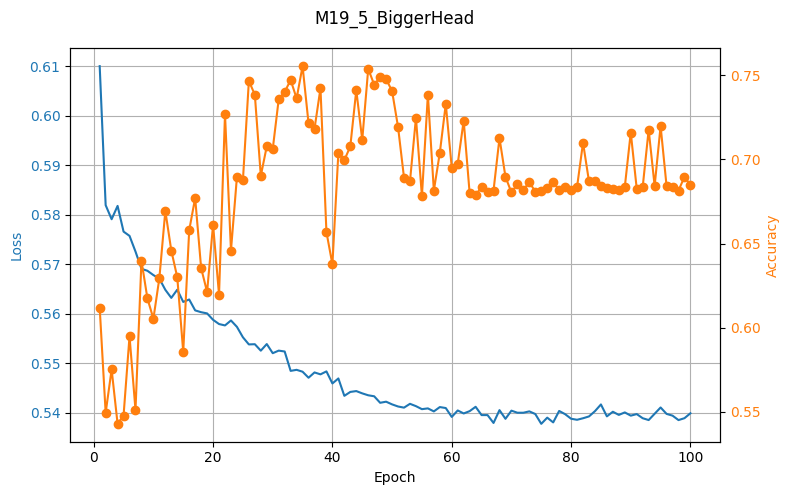

In [50]:
# run_experiment(Model8_Bottleneck1x1, "Model_8", 100)
# run_experiment(Model9_VGGLite, "Model_9", 100)
# run_experiment(Model10_MorePooling, "Model_10", 100)
# run_experiment(Model11_CappedChannels, "Model_11", 100)
# run_experiment(Model12_ShrinkBeforeFC, "Model_12", 100)
# run_experiment(Model15_2conv_stages, "Model_15", 100)
# run_experiment(Model22_extra_conv_mid, "Model_22", 100)
# run_experiment(Model14_VGGmini_morepool, "Model_14", 100)
# run_experiment(Model21_late64, "Model_21", 100)
# run_experiment(Model20_all32, "Model_20", 100)
# run_experiment(Model13_VGGmini, "Model_13", 100)
# run_experiment(Model16_wide_early, "Model_16", 100)
# run_experiment(Model17_deeper_4blocks, "Model_17", 100)
# run_experiment(Model18_bigger_head, "Model_18", 100)
# run_experiment(Model19_lowchan_deeper, "Model_19", 100)
run_experiment(M6_1_WiderEarly, "M6_1_WiderEarly", 100)
run_experiment(M6_2_StrongerLate, "M6_2_StrongerLate", 100)
run_experiment(M6_3_ExtraConvMid, "M6_3_ExtraConvMid", 100)
run_experiment(M6_4_BiggerHead, "M6_4_BiggerHead", 100)
run_experiment(M6_5_BottleneckMid, "M6_5_BottleneckMid", 100)
run_experiment(M13_1_ExtraConvEarly, "M13_1_ExtraConvEarly", 100)
run_experiment(M13_2_Wider, "M13_2_Wider", 100)
run_experiment(M13_3_Extra1x1Late, "M13_3_Extra1x1Late", 100)
run_experiment(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC", 100)
run_experiment(M13_5_WithDropout, "M13_5_WithDropout", 100)
run_experiment(M19_1_SlightlyWider, "M19_1_SlightlyWider", 100)
run_experiment(M19_2_LastTo32, "M19_2_LastTo32", 100)
run_experiment(M19_3_ExtraConvMid, "M19_3_ExtraConvMid", 100)
run_experiment(M19_4_BottleneckBeforeC3, "M19_4_BottleneckBeforeC3", 100)
run_experiment(M19_5_BiggerHead, "M19_5_BiggerHead", 100)